<a href="https://colab.research.google.com/github/ELGHAZI-85/ml-student/blob/main/Copie_de_Land_Cover_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Land Cover Type Classification with PyTorch

This notebook serves as a starting point for your machine learning project on land cover type classification.

The task at hand involves classifying land cover types, such as 'Forest,' 'River,' 'Highway,' and more, based on satellite images. The dataset consists of images labeled with their corresponding land cover types. The goal is to train a machine learning model that can accurately predict the land cover type of new, unseen images.

In this notebook, you'll find code snippets to load and visualize the data, providing insights into the images and their labels.

## Build Your Model

You have the freedom to choose the architecture or model for your land cover classification task. Whether you opt for a simple convolutional neural network (CNN) or explore transfer learning with pre-trained models, the notebook provides a flexible starting point. Experiment with different architectures to achieve the best performance.

## Model Training and Evaluation

Once your model is defined, the notebook guides you through the process of training it on the dataset. Additionally, it includes code to evaluate the model's performance on the validation and test sets.

Feel free to modify, experiment, and enhance the provided code. Happy coding !

Please submit your weekly assignments to me via [email](mailto:elmontassir@cerfacs.fr) to receive your score on the test set.



# Data

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tarfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

In [7]:
random.seed(10)

In [8]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("You are on GPU !")
else:
  print('Change the runtime to GPU or continue with CPU, but this should slow down your trainings')
  device = torch.device("cpu")

Change the runtime to GPU or continue with CPU, but this should slow down your trainings


In [9]:
# Loading the dataset
!wget -nv https://cerfacs.fr/opendata/cours/data/TRAIN.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/TEST.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/y_train.npy

2023-12-29 20:15:51 URL:https://cerfacs.fr/opendata/cours/data/TRAIN.tar [44851200/44851200] -> "TRAIN.tar" [1]
2023-12-29 20:15:53 URL:https://cerfacs.fr/opendata/cours/data/TEST.tar [15687680/15687680] -> "TEST.tar" [1]
2023-12-29 20:15:55 URL:https://cerfacs.fr/opendata/cours/data/y_train.npy [1600128/1600128] -> "y_train.npy" [1]


In [10]:
# Using tarfile to create np arrays
def extract_files(dataset):
    tar = tarfile.open(dataset+'.tar', 'r')
    names = tar.getmembers()[:]
    images = [tar.extractfile(name) for name in names]
    return np.array([np.array(Image.open(image)) for image in images])

In [11]:
X_train = extract_files('TRAIN')
X_test = extract_files('TEST')
y_train = np.load('y_train.npy').reshape(-1, 1)
print("Train data : ",X_train.shape)
print("Train labels", y_train.shape)
print("Test data : ",X_test.shape)

Train data :  (20000, 64, 64, 3)
Train labels (20000, 1)
Test data :  (7000, 64, 64, 3)


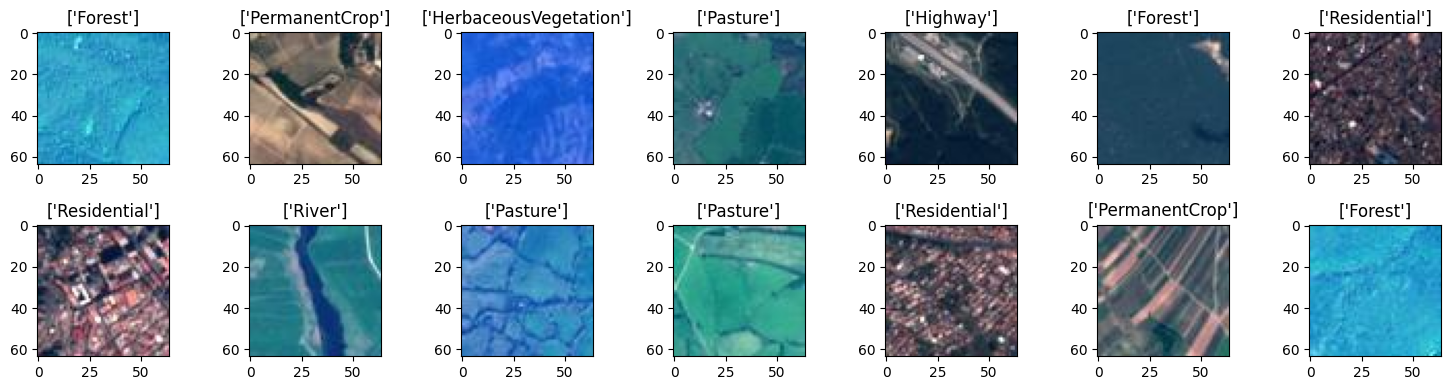

In [12]:
# Display data samples
fig, axes = plt.subplots(2, 7, figsize=(15, 4))
axes = axes.ravel()
for i in range(14):
    axes[i].imshow(X_train[i])
    axes[i].set_title(y_train[i])
plt.tight_layout()

There are 10 possible classes for each image (only one per image is correct):

  - 'AnnualCrop'
  - 'Forest'
  - 'HerbaceousVegetation'
  - 'Highway'
  - 'Industrial'
  - 'Pasture'
  - 'PermanentCrop'
  - 'Residential'
  - 'River'
  - 'SeaLake'

We could simply code an integer value for each: 'AnnualCrop' = 0, 'Forest' = 1, etc... This is known as "Ordinal Encoding", and has some drawbacks, e.g. if the network is unsure whether it is class 0 or 2, it could end up saying 1, which is another class altogether. When categories have a natural order, ordinal encoding can be a good way to go. Here, this is not the case.

The most classical way to convert the type of labels here to numeric values is through [**one-hot encoding**](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features). In this process, the label is converted to a vector with length the number of possible labels, and only the one matching the true label is set to 1, all others are set to 0.

|                 | Type1 | Type2 | Type3 |   | Label Vector |
|-----------------|:-----:|:-----:|:-----:|---|:------------:|
| Sample1: Type 2 |   0   |   1   |   0   |   |   [0, 1, 0]  |
| Sample2: Type 2 |   0   |   1   |   0   |   |   [0, 1, 0]  |
| Sample3: Type 1 |   1   |   0   |   0   |   |   [1, 0, 0]  |
| ...             |       |       |       |   |              |

Scikit-learn has a useful class for this, [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), which does this automatically. More importantly, it remembers the encoding, and you can use it again after making your final predictions te *decode* them back to text labels, as expected by the competition.

In [13]:
# Convert labels to one-hot encoding
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train).toarray()

# Model

Note: the images here are encoded with 8-bit integers, *i.e.* between 0 and 255. A normalization is needed.

In [14]:
# Prepare data for training
X_train, X_test = X_train/255, X_test/255
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))
print(mean)
print(std)

[0.29088279 0.41201959 0.48920503]
[0.2240432  0.17601508 0.21699366]


The normalization coefficients for the mean and standard deviation are commonly used for image data normalization within the range of [0, 255] or [0, 1]. This process brings pixel values into a standard range centered around zero, facilitating the acceleration of neural network training. In this case, we begin by dividing by 255 to scale values to [0, 1]. Subsequently, subtracting the mean centers the range around zero, and dividing by the standard deviation reduces the range to a centered Gaussian distribution, promoting stability.

Normalization coefficients may vary depending on the dataset, image characteristics, and network architecture. Experimenting with different strategies is common in model development. For specific datasets, calculating the mean and standard deviation directly from the training data can provide a good normalization.

In [15]:
# Assuming X_train and y_train are PyTorch tensors
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors and normalize images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

X_train_tensor = torch.stack([transform(img) for img in X_train]).float()
X_valid_tensor = torch.stack([transform(img) for img in X_valid]).float()
X_test_tensor = torch.stack([transform(img) for img in X_test]).float()
y_train_tensor = torch.from_numpy(y_train)
y_valid_tensor = torch.from_numpy(y_valid)
num_classes = 10

In [16]:
####################### 5
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size = (7,7), stride = (2,2), padding = (3,3), bias=False)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # !here
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1);
        self.bn3 = nn.BatchNorm2d(256);

        self.global_pooling = nn.AdaptiveAvgPool2d(1)

        self.fc1 = nn.Linear(256, 1024)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout2d(p=0.2)
        # ! end here

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.max_pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.lp_pool2d(x, norm_type=2, kernel_size=2, stride=2)
        #! here
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.lp_pool2d(x, norm_type=2, kernel_size=2, stride=2)
        x = self.global_pooling(x)
        # here
        total_elements = x.numel()
        desired_shape = (x.size(0), -1)
        x = x.view(*desired_shape)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.dropout(x)
        return x

In [ ]:
####################### 6
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size = (7,7), stride = (2,2), padding = (3,3), bias=False)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # !here
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1);
        self.bn3 = nn.BatchNorm2d(256);

        self.conv4 = nn.Conv2d(256, 1024, kernel_size=3, stride=1, padding=1);
        self.bn4 = nn.BatchNorm2d(1024);

        self.global_pooling = nn.AdaptiveAvgPool2d(1)

        self.fc1 = nn.Linear(1024, 2048)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(2048, 512)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout2d(0.1)
        # ! end here

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.max_pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.lp_pool2d(x, norm_type=2, kernel_size=2, stride=2)
        #! here
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.lp_pool2d(x, norm_type=2, kernel_size=2, stride=2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.lp_pool2d(x, norm_type=2, kernel_size=2, stride=2)

        x = self.global_pooling(x)
        # here
        #torch.Size([32, 256, 8, 8])
        #x = self.global_pooling(x)

        total_elements = x.numel()
        # Desired shape after flattening (for example, connecting to a fully connected layer)
        desired_shape = (x.size(0), -1)
        # Apply view
        x = x.view(*desired_shape)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.dropout(x)
        return x

In [ ]:
# Instantiate the model
model = SimpleCNN().to(device)

# Print the model architecture
print(model)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)  # You can set learning rate, weight decay, etc.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
num_epochs = 30
batch_size = 128


# Assuming X_train_tensor and y_train_tensor are torch tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor.float())
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pooling): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=1024, out_features=2048, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2048, out_features=512, bi

In [17]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting losses
    plt.subplot(1, 2, 1)
    # plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracies
    plt.subplot(1, 2, 2)
    # plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [ ]:
# Initialize lists to store training and validation metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

    # Evaluation on the validation set
    model.eval()
    with torch.no_grad():
        valid_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels.argmax(dim=1)).sum().item()

    # Calculate metrics
    avg_train_loss = 0.0  # Replace with your actual training loss
    train_accuracy = 0.0  # Replace with your actual training accuracy
    avg_valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = correct / total

    # Print and store metrics
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_valid_loss:.3f}, Accuracy: {100*valid_accuracy:.2f}%')
    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

Epoch 1/30, Validation Loss: 0.358, Accuracy: 90.62%
Epoch 2/30, Validation Loss: 0.320, Accuracy: 91.57%
Epoch 3/30, Validation Loss: 0.333, Accuracy: 91.07%
Epoch 4/30, Validation Loss: 0.309, Accuracy: 91.35%
Epoch 5/30, Validation Loss: 0.455, Accuracy: 89.08%
Epoch 6/30, Validation Loss: 0.345, Accuracy: 91.20%
Epoch 7/30, Validation Loss: 0.389, Accuracy: 91.88%
Epoch 8/30, Validation Loss: 0.424, Accuracy: 90.15%
Epoch 9/30, Validation Loss: 0.373, Accuracy: 91.75%
Epoch 10/30, Validation Loss: 0.398, Accuracy: 91.25%
Epoch 11/30, Validation Loss: 0.585, Accuracy: 88.52%
Epoch 12/30, Validation Loss: 0.366, Accuracy: 91.30%
Epoch 13/30, Validation Loss: 0.357, Accuracy: 91.83%
Epoch 14/30, Validation Loss: 0.420, Accuracy: 90.35%
Epoch 15/30, Validation Loss: 0.469, Accuracy: 90.10%
Epoch 16/30, Validation Loss: 0.375, Accuracy: 91.53%
Epoch 17/30, Validation Loss: 0.654, Accuracy: 87.28%
Epoch 18/30, Validation Loss: 0.531, Accuracy: 90.05%
Epoch 19/30, Validation Loss: 0.489, 

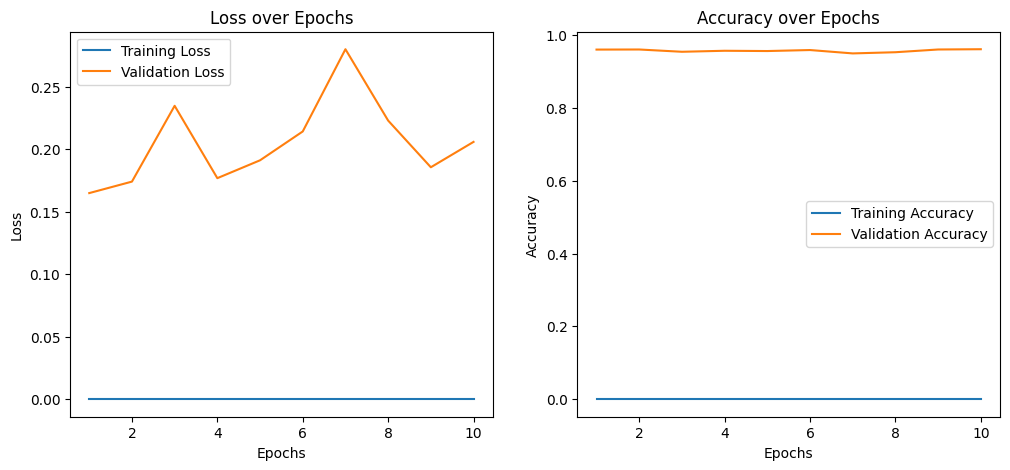

In [ ]:
# Plot learning curves
plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies)

## **Resnet-18**

In [18]:
# Resnet------------------------------------------------------------
from torchvision import datasets, models, transforms




In [92]:


class ResNet(nn.Module):
    def __init__(self, num_classes):
        # Define your ResNet (18, 34 or 50) architecture
        super(ResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        # self.fc1 = nn.Linear(1024, 512)
        # self.dropout1 = nn.Dropout(0.1)

        # self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Define the forward pass
        x = self.model(x)
        # x = F.relu(self.fc1(x))
        # x = self.dropout1(x)
        # x = self.fc2(x)
        return x

In [23]:
class ResNet(nn.Module):
    def __init__(self, num_classes):
        # Define your ResNet (18, 34 or 50) architecture
        super(ResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 256)
        self.fc1 = nn.Linear(256, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(128, num_classes)


    def forward(self, x):
        # Define the forward pass
        x = self.model(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)

        return x

In [24]:
model = ResNet(num_classes=10).to(device)
print(model)


ResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)  # You can set learning rate, weight decay, etc.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
num_epochs = 30
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor.argmax(dim=1))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor.argmax(dim=1))
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Initialize lists to store training and validation metrics

valid_losses = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

    # Evaluation on the validation set
    model.eval()
    with torch.no_grad():
        valid_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Calculate metrics
    avg_valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = correct / total

    # Print and store metrics
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_valid_loss:.3f}, Accuracy: {100*valid_accuracy:.2f}%')

    valid_losses.append(avg_valid_loss)

    valid_accuracies.append(valid_accuracy)

[0.6385025874376297, 0.42868655335903166, 0.4256697578430176, 0.30810187020897867, 0.35544882926344873, 0.826109502196312, 0.3201828480362892, 0.316193098410964, 0.3651239598989487, 0.31091029743105175, 0.2899514047242701, 0.3740557275721803, 0.33502730054408314, 0.38659156815707685, 0.330448545768857, 0.3744876545602456, 0.3568739608898759, 0.304547544978559, 0.4113825810700655, 0.3391880189348012, 0.4444515439737588, 0.6789837039113045, 0.42994723182171585, 0.4398044671267271, 0.38067284104600546, 0.5196623658016324, 0.4395377130955458, 0.5125527591854334, 0.35253164286585525, 0.3976657724548131]
[0.803, 0.87, 0.878, 0.90925, 0.9055, 0.8155, 0.9055, 0.91475, 0.90125, 0.92175, 0.9225, 0.913, 0.90925, 0.89925, 0.913, 0.9135, 0.908, 0.9215, 0.906, 0.92275, 0.91375, 0.849, 0.90675, 0.894, 0.9095, 0.9005, 0.91925, 0.897, 0.921, 0.914]


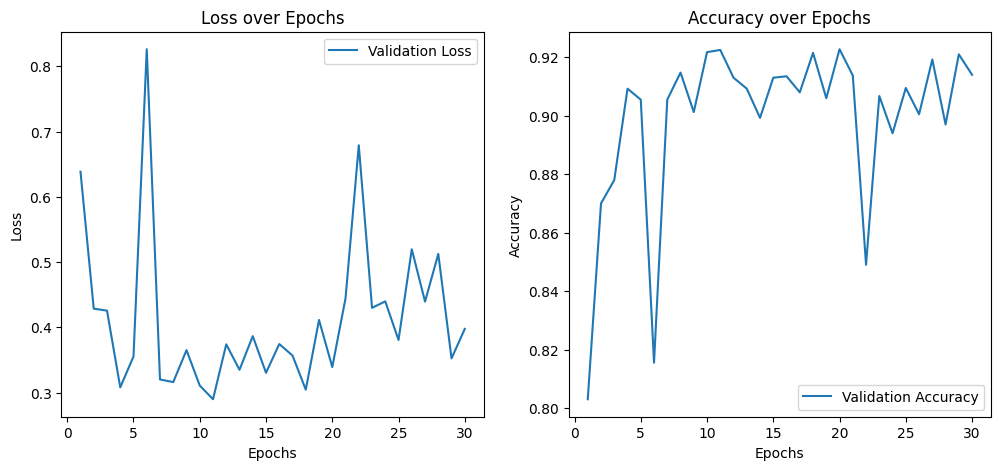

In [103]:
# Plot learning curves RESNET34 9
print(valid_losses)
print(valid_accuracies)
plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies)

[0.30884732937812803, 0.30384341141581533, 0.30064900332689287, 0.31737488907575606, 0.26385247242450716, 0.29387075825035575, 0.26380736062675714, 0.3517510543167591, 0.24349270663037897, 0.31387261536717415, 0.33177583395689725, 0.2808230942636728, 0.33914548698812724, 0.30787343155872077, 0.3134468621108681, 0.2975530432909727, 0.37562146899849175, 0.3558344785571098, 0.3628948801420629, 0.4025962122008204, 0.3720642759948969, 0.42474685951508584, 0.28819373600184917, 0.6948828945308924, 0.3429585570432246, 0.421325757291168, 0.6030386229455471, 0.31077793055260555, 0.346924803274218, 0.3271399932280183]
[0.89975, 0.89675, 0.903, 0.906, 0.914, 0.913, 0.916, 0.90375, 0.928, 0.9075, 0.91075, 0.91625, 0.90475, 0.921, 0.927, 0.91575, 0.90675, 0.91, 0.91175, 0.89975, 0.9125, 0.90375, 0.926, 0.862, 0.92125, 0.912, 0.862, 0.9235, 0.91975, 0.912]


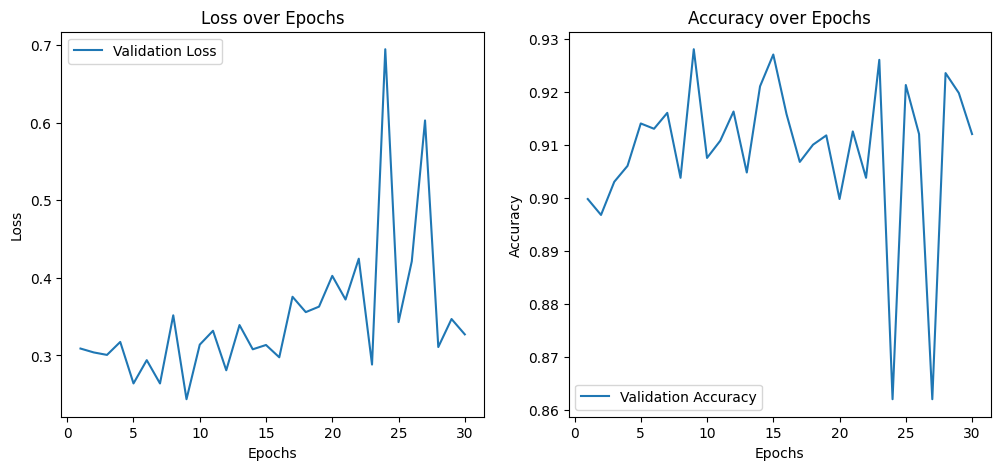

In [98]:
# Plot learning curves RESNET50
print(valid_losses)
print(valid_accuracies)
plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies)

[0.4618648861646652, 0.29004618829488754, 0.28466629043221475, 0.29299871130287647, 0.2481764035820961, 0.30960348384082315, 0.28459004605561494, 0.3105072425529361, 0.2731814806163311, 0.25408526594750586, 0.28255935540795324, 0.32013095301389694, 0.27904173704236745, 0.41218466497957706, 0.27667251527681946, 0.3919485788941383, 0.3068844870887697, 0.29803440932556985, 0.3361567873954773, 0.29085435745492577, 0.43498995384573935, 0.4232534395828843, 0.3512677180767059, 0.3633823798969388, 0.3568896953798831, 0.36570875952765347, 0.386823492301628, 0.34323564914241433, 0.34625560136884453, 0.4955570157915354]
[0.84425, 0.90425, 0.9065, 0.90475, 0.92225, 0.909, 0.9145, 0.91275, 0.919, 0.929, 0.92325, 0.9125, 0.92325, 0.88425, 0.92375, 0.90275, 0.91125, 0.92675, 0.91625, 0.92375, 0.89725, 0.90075, 0.92, 0.9175, 0.91525, 0.91525, 0.913, 0.926, 0.91975, 0.887]


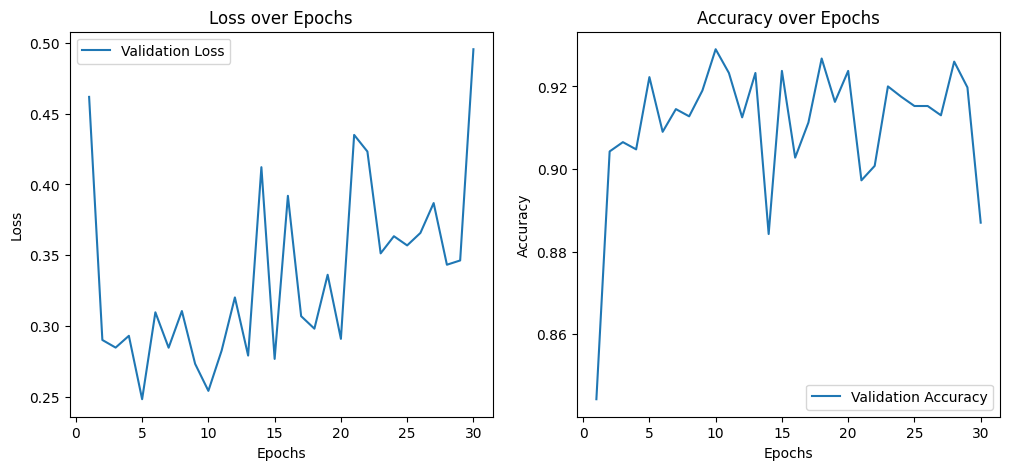

In [17]:
# Plot learning curves RESNET18
print(valid_losses)
print(valid_accuracies)
plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies)

## **EfficientNet-B4**

In [ ]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=776edb9117aa85290c24b626c4991b59cc6d313edcedda071ee10152861d0f3a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
class EfficientNetB4(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB4, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=num_classes)

    def forward(self, x):
        return self.model(x)


In [ ]:
model = EfficientNetB4(num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 10
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation (similar to your previous code)
    model.eval()
    with torch.no_grad():
        valid_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels.argmax(dim=1)).sum().item()

    # Calculate metrics
    avg_train_loss = 0.0  # Replace with your actual training loss
    train_accuracy = 0.0  # Replace with your actual training accuracy
    avg_valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = correct / total

    # Print and store metrics
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_valid_loss:.3f}, Accuracy: {100*valid_accuracy:.2f}%')
    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

Epoch 1/10, Validation Loss: 0.196, Accuracy: 95.62%
Epoch 2/10, Validation Loss: 0.154, Accuracy: 96.55%
Epoch 3/10, Validation Loss: 0.184, Accuracy: 96.33%
Epoch 4/10, Validation Loss: 0.234, Accuracy: 95.60%
Epoch 5/10, Validation Loss: 0.194, Accuracy: 96.10%
Epoch 6/10, Validation Loss: 0.223, Accuracy: 95.12%
Epoch 7/10, Validation Loss: 0.177, Accuracy: 95.97%
Epoch 8/10, Validation Loss: 0.196, Accuracy: 96.25%


# Create Your Submission

In [ ]:
# Function to create a submission file
def create_submission(predictions):
    assert predictions.shape == (7000, 1), f"Wrong shape for your prediction file : {predictions.shape} instead of (7000, 1)"
    with open('predictions.npy', 'wb') as f:
      np.save(f, predictions)
    print("File predictions.npy created !")

In [ ]:
# Generate predictions
bs = 35
predictions = np.ones((X_test_tensor.shape[0],10))
for i in range(X_test_tensor.shape[0]//bs):
  predictions[bs*i:bs*(i+1),:] = model(X_test_tensor[bs*i:bs*(i+1)].to(device)).cpu().detach().numpy()
print(predictions[:5])

# Get labels
predictions = encoder.inverse_transform(predictions)
print(predictions[:5])

# Create a submission using the provided function
NAME = "EL GHAZI Fatima & TONLEU Brenda"
NUMBER = 1
create_submission(predictions)

[[ -0.36302993  -0.30232149  -1.51812124   3.05814695 -11.11825371
    7.15018511  -1.46435726 -11.23411083   1.83601856  -1.07842863]
 [-12.43370724 -11.68141651   2.53569961   6.55628395  15.72836018
  -16.58943176  -3.08035398   1.3842622   -2.48926163  -9.17602253]
 [  0.70407695 -12.92386818   6.21842098   2.13954163 -10.31416512
   -2.75293994   9.53725052  -8.20730686  -2.29543161  -5.99865341]
 [  0.25898197   6.91994572   0.17632341  -4.93744898 -11.98591232
    0.43033573  -4.16947365  -6.26963663  -0.08004163   1.16067243]
 [-11.0111599   -7.39525795   2.28245282   8.09958935  -4.0595603
   -5.34816504  -1.93266213  -4.55452156   9.86158657  -5.63954735]]
[['Pasture']
 ['Industrial']
 ['PermanentCrop']
 ['Forest']
 ['River']]
File predictions.npy created !
